# Data-Driven Movie Recommendation System

https://github.com/mizumoto-cn/CSCA5632Final

In the era of information overload, personalized recommendation systems play a crucial role in filtering and delivering relevant content to users. This project presents a baseline Movie Recommendation System built using the Netflix Prize data. The system employs collaborative filtering, a common approach in recommendation systems, to predict the rating or preference that a user would give to an item.

This project also explores the use of hybrid methods with correlations for generating recommendations. The system aims to enhance the quality of search results and provide items that are more relevant to the user’s search history or preferences. The effectiveness of such recommendation systems has significant implications for user satisfaction and engagement, making them integral to the success of major tech companies like Amazon, YouTube, Facebook, Netflix, and Spotify.

## EDA
(Understanding, Processing and Warehousing)

### Data Loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
from scipy.sparse import csr_matrix
import seaborn as sns
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, KFold

sns.set_style("darkgrid")

In [2]:
# drop date
df1 = pd.read_csv('../input/netflix-prize-data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Netflix Prize data - Dataset 1 shape: {}'.format(df1.shape))

print(df1.iloc[::5000000, :])

Netflix Prize data - Dataset 1 shape: (24058263, 2)
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


The dataset is kinda big, may take tens of seconds to load.

Then you may load the other 3 datasets as well.

In [3]:
df2 = pd.read_csv('../input/netflix-prize-data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('../input/netflix-prize-data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('../input/netflix-prize-data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


And combine them up:

In [4]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

df.index = np.arange(0,len(df))
print('Netflix Prize data - Full dataset shape: {}'.format(df.shape))
print(df.iloc[::5000000, :])

Netflix Prize data - Full dataset shape: (100498277, 2)
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


### Data Understanding

We can try to tell what kind of information the datasets tell, by looking at how the data spread.

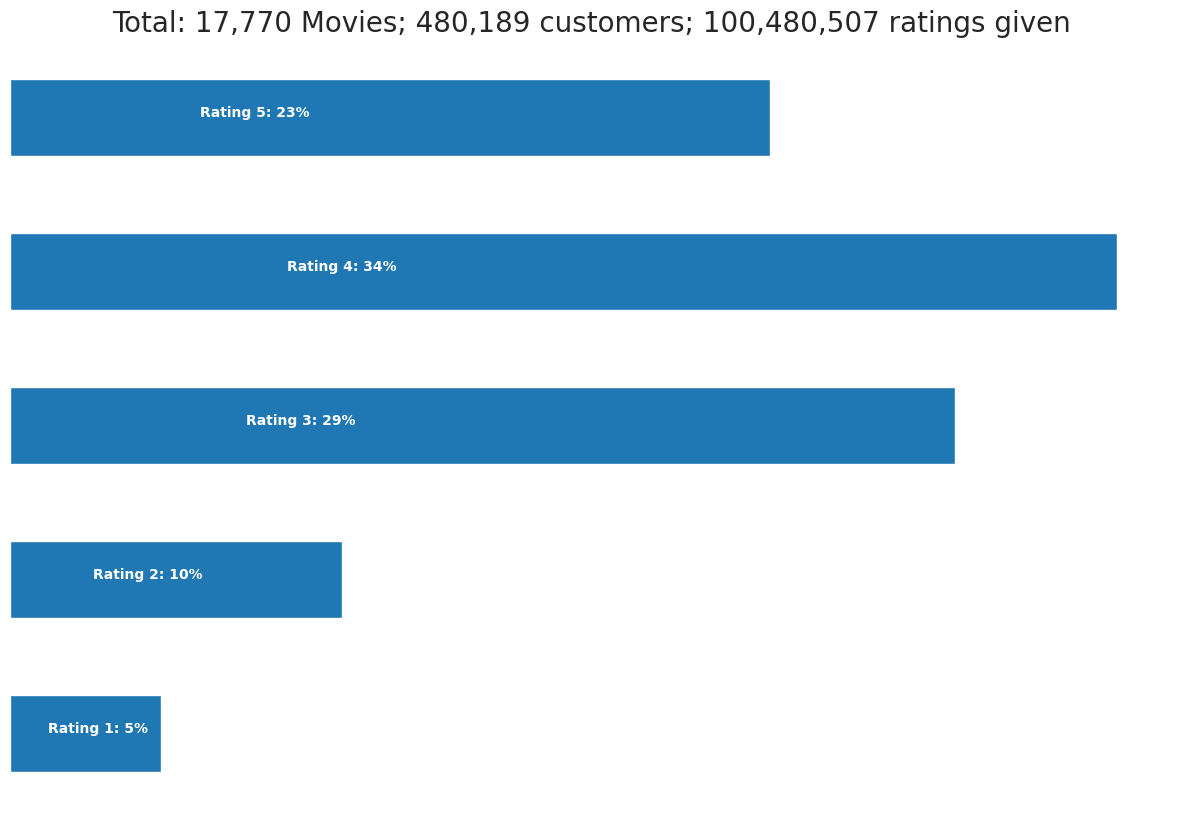

In [5]:

p = df.groupby('Rating')['Rating'].agg(['count'])

# Calculate the movie count (number of NaN values in the 'Cust_Id' column)
movie_count = df.isnull().sum().iloc[1]

# Calculate the customer count (unique 'Cust_Id' count minus movie_count)
cust_count = df['Cust_Id'].nunique() - movie_count

# Calculate the rating count (total count of 'Cust_Id' minus movie_count)
rating_count = df['Cust_Id'].count() - movie_count


ax = p.plot(kind='barh', legend=False, figsize=(15, 10))
plt.title('Total: {:,} Movies; {:,} customers; {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

# Annotate the chart with percentage labels for each rating
for i in range(1, 6):
    # Calculate the position and percentage for annotation
    position = i - 1
    percentage = p.iloc[position].iloc[0] * 100 / p.sum().iloc[0]
    
    # Add the annotation to the chart
    ax.text(p.iloc[position].iloc[0] / 4, position, 'Rating {}: {:.0f}%'.format(i, percentage), color='white', weight='bold')


Upon reviewing the data, we noted a tendency for the ratings to skew positively, with most ratings exceeding 3. This observation could be attributed to the likelihood that dissatisfied customers often choose not to rate at all, rather than providing a low rating. This is an important consideration for our analysis, as it suggests that movies with low ratings are generally of poor quality.

### Data Cleaning

The importation of the Movie ID presented a significant challenge due to its disorganized nature. A direct loop through the dataframe to add the Movie ID column proved to be inefficient and exceeded the memory capacity of the Kernel. To overcome this, we devised an alternative approach: we first created a numpy array of the correct length, then added this array as a column to the main dataframe. This method proved to be both efficient and effective.

In [6]:
# dataframe too big, use df1 for presentation
df = df1

# Create a DataFrame indicating NaN values in the 'Rating' column
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]

df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

# Iterate through consecutive NaN index pairs to assign movie IDs
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for the last record and its corresponding length
# Numpy approach: Create an array of movie_id with length (len(df) - df_nan.iloc[-1, 0] - 1)
last_record = np.full((1, len(df) - df_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


This may take a long time. So I only used df1 for presentation.

In [7]:
# Remove rows with missing 'Rating' values
df = df[pd.notnull(df['Rating'])].copy()

df.loc[:, 'Movie_Id'] = movie_np.astype(int)

# Convert 'Cust_Id' column to integer type using .loc to avoid SettingWithCopyWarning
df.loc[:, 'Cust_Id'] = df['Cust_Id'].astype(int)

print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


### Data Slicing

The datasets have such large volume that you may get "out of memory" errors.

Also, ratings records for extremely unpopular movies or extremely inactive users can lead to potential bias in training results, so I decided to remove the following two types of records: 
- Remove movies with too few reviews (they are relatively unpopular)
- Remove customers with too few reviews (they are relatively inactive and don't necessarily have their own standardized rating scale)


Implementing the aforementioned benchmark will significantly enhance efficiency and significance.
Since treating both unpopular movies and inactive customers the same way as popular movies and active customers in the matrix (while acknowledging that NaN still occupies space), this approach not only optimizes space utilization but also contributes to increased statistical significance.

In [8]:
f = ['count', 'mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)

df_movie_summary.index = df_movie_summary.index.map(int)

movie_benchmark = round(df_movie_summary['count'].quantile(0.7), 0)

# Identifying movies with review counts below the threshold
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

# Grouping by Cust_Id and calculating aggregated statistics
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)

df_cust_summary.index = df_cust_summary.index.map(int)

# Determining the review count threshold for customers
cust_benchmark = round(df_cust_summary['count'].quantile(0.7), 0)

# Identifying customers with review counts below the threshold
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))


Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


Trim down:

In [9]:
print('Original Shape: {}'.format(df.shape))

# Removing rows associated with movies in the drop list
df = df[~df['Movie_Id'].isin(drop_movie_list)]

# Removing rows associated with customers in the drop list
df = df[~df['Cust_Id'].isin(drop_cust_list)]

print('After Trim Shape: {}'.format(df.shape))

print(df.iloc[::5000000, :])


Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


pivot:

In [10]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)


(143458, 1350)


Pivoted the data set and put it into matrices.

### Data Mapping

In [11]:
df_title = pd.read_csv('../input/netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'], usecols = [0, 1, 2])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


## Recommendation Models

### Collaborative Filtering

Evalute performance of collaborative filtering

#### MySVD defines a helper class of SVD using sklearn

In [36]:

from sklearn.decomposition import NMF

class RecSys():
    def __init__(self,data):
        self.data=data
        self.allusers = list(self.data.users['Cust_Id'])
        self.allmovies = list(self.data.movies.index)
#         self.genres = list(self.data.df_title.columns.drop(['Movie_Id', 'title', 'year']))
        self.mid2idx = dict(zip(self.data.movies.index,list(range(len(self.data.movies)))))
        self.uid2idx = dict(zip(self.data.users.Cust_Id,list(range(len(self.data.users)))))
        self.Mr=self.rating_matrix()
        self.sim=np.zeros((len(self.allmovies),len(self.allmovies)))
        
    def rating_matrix(self):
        ind_movie = [self.mid2idx[x] for x in self.data.train.Movie_Id] 
        ind_user = [self.uid2idx[x] for x in self.data.train.Cust_Id]
        rating_train = list(df.Rating)
        return csr_matrix((rating_train, (ind_user, ind_movie)), shape=(len(self.allusers), len(self.allmovies)))

    def spy_rating_matrix(self):
        fig,ax=plt.subplots(figsize=(5,10))
        plt.spy(self.Mr,markersize=0.05);
        ax.set_xlabel('movies')
        ax.set_ylabel('users')
        s = 100*(1 - (self.Mr.nnz)/np.prod(self.Mr.shape))
        ax.set_title('Rating matrix from training set. Missing = {:.2f}%'.format(s))
    
    def plot_ratings_per_user_and_movie(self):
        fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(12,7))
        n_ratings_per_movie = self.Mr.getnnz(axis=0)
        n_ratings_per_user = self.Mr.getnnz(axis=1)
        ax = axs[0,0]
        sns.histplot(n_ratings_per_movie,ax=ax,kde=True,palette='colorblind')
        ax.set_xlabel('ratings per movie');
        ax.set_title('Movies');
        m = np.median(n_ratings_per_movie)
        ax.axvline(m,linestyle='--',color='r',alpha=0.5,label='median={}'.format(m))
        ax.legend();
        ax = axs[0,1]
        sns.histplot(n_ratings_per_user,ax=ax,kde=True,palette='colorblind')
        ax.set_xlabel('ratings per user');
        ax.set_title('Users');
        m = np.median(n_ratings_per_user)
        ax.axvline(m,linestyle='--',color='r',alpha=0.5,label='median={}'.format(m))
        ax.legend();
        # Box plots
        ax = axs[1,0]
        sns.boxplot(data=n_ratings_per_movie,ax=ax,palette='colorblind',orient='h')
        ax.set_xlabel('ratings per movie');
        ax.set_yticklabels(['movie']);
        ax = axs[1,1]
        sns.boxplot(data=n_ratings_per_user,ax=ax,palette='colorblind',orient='h')
        ax.set_xlabel('ratings per user');
        ax.set_yticklabels(['user']);
        fig.suptitle('Marginal distribution of ratings per user or movies in training dataset',size=14);
    def plot_avg_movie_ratings(self):
        n_ratings, avg_ratings = self.get_ratings_per_movie_and_avg_rating()
        r = np.corrcoef(avg_ratings,n_ratings)[0,1]
        print('Corr coef: {:.1f}'.format(r))
        df = pd.DataFrame({'Number of ratings per movie':n_ratings,
                     'Average movie rating':avg_ratings})
        sns.jointplot(data=df, x='Number of ratings per movie', y='Average movie rating', kind="reg");
    def get_ratings_per_movie_and_avg_rating(self):
        n_ratings_per_movie = self.Mr.getnnz(axis=0)
        ind_rated=np.where(n_ratings_per_movie!=0)
        n_ratings_per_movie = n_ratings_per_movie[ind_rated]
        avg_movie_ratings = self.Mr.sum(axis=0).A1[ind_rated]/n_ratings_per_movie
        return n_ratings_per_movie,avg_movie_ratings  
    def count_movies_without_rating(self):
        n_ratings_per_movie = self.Mr.getnnz(axis=0)
        return len(n_ratings_per_movie[n_ratings_per_movie==0])
    def count_users_without_rating(self):
        n_ratings_per_user = self.Mr.getnnz(axis=1)
        return len(n_ratings_per_user[n_ratings_per_user==0])
    def predict_everything_to_k(self,k):
        # your code here
        return np.full_like(self.data.test.rating,k)
        
    def predict_to_user_average(self):
        # your code here
        userIDs = self.data.test['Cust_Id']
        user_means = self.data.train.groupby('Cust_Id')['Rating'].mean()
        return user_means[userIDs]
        
    def rmse(self,yp):
        yp[np.isnan(yp)]=3 
        yt=np.array(self.data.test.rating)
        return np.sqrt(((yt-yp)**2).mean())
    
class RecSysNMF(RecSys):
    def __init__(self,data):
        super().__init__(data)
        self.Mr_imp=None
    def impute_simpleNMF(self,n_groups,**NMF_params):
        self.Mr_imp = None # free space
        self.Mr_imp = self.sparse_simple_NMF_imputation(n_groups,**NMF_params) 
    def impute_iterNMF(self,n_groups,max_iter=20,tol=1e-3,**NMF_params):
        self.Mr_imp = None # free space
        self.Mr_imp,_,_ = self.sparse_iterative_NMF_imputation(n_groups, max_iter, tol, **NMF_params) 
    def sparse_simple_NMF_imputation(self,n_groups,**NMF_params):
        Xsimple = self.Mr.copy().A # full matrix representation
        _, H,W= create_NMF_groups(Xsimple,n_groups,**NMF_params)
        Xsimple = W@H
        RecSysNMF.replace_vals_from_sparse(Xsimple,self.Mr)   
        return Xsimple
    def sparse_iterative_NMF_imputation(self,n_groups,max_iter=20,tol=1e-3,**NMF_params):
        X0 =  self.Mr.copy().A # full matrix representation
        for iterations in range(max_iter):
            _, H,W= create_NMF_groups(X0,ngroups = n_groups,**NMF_params)  
            X1 = W@H
            RecSysNMF.replace_vals_from_sparse(X1,self.Mr)  
            fobj = np.linalg.norm(X1-X0)
            if fobj<tol:
                break
            X0=X1        
        return X1,fobj, iterations
    
    def predict(self):
        ind_movie = [self.mid2idx[x] for x in self.data.test.Movie_Id] 
        ind_user = [self.uid2idx[x] for x in self.data.test.Cust_Id]
        return self.Mr_imp[(ind_user,ind_movie)]     
    @staticmethod
    def replace_vals_from_sparse(X,Ysparse):
        nrows = len(Ysparse.indptr)-1
        for row in range(nrows):
            aux_ind = range(Ysparse.indptr[row],Ysparse.indptr[row+1])
            cols = Ysparse.indices[aux_ind]
            X[row,cols]=Ysparse.data[aux_ind]
            
    def compare_avg_movie_rating_histograms(self,title=None):
        _, avg_ratings_orig = self.get_ratings_per_movie_and_avg_rating()
        avg_ratings_computed = np.mean(self.Mr_imp,axis=0)
        df1 = pd.DataFrame({'avg movie rating':avg_ratings_orig,'source':'orig. train set'})
        df2 = pd.DataFrame({'avg movie rating':avg_ratings_computed,'source':'computed'})
        df = pd.concat([df1,df2],ignore_index=True)
        if title is None:
            title= 'Effect of data imputation in the distribution of average movie rating'
        sns.kdeplot(data = df,x='avg movie rating',hue='source',palette='colorblind').set(
            title=title)  

def create_NMF_groups(X,ngroups = 3,**NMF_params):    
    nmf_model = NMF(n_components=ngroups,init='nndsvda',**NMF_params).fit(X) 
    H = nmf_model.components_
    W = nmf_model.transform(X)
    return nmf_model, H,W


In [13]:
print("""NMF model:
rmse : 2.1191572377280197
solver : mu
beta_loss : kullback-leibler
p : 30""")
print("""NMF model:
rmse : 1.7057493249049387 
solver : cd
beta_loss : frobenius
p : 20
max_iter : 10""")

from collections import namedtuple
from tqdm import tqdm
Data = namedtuple('Data', ['users','movies', 'train', 'test'])
data = Data(df, df_title, df, df)
RS = RecSysNMF(data)
pp = [1,3,5,10,20,30]
# fig,ax = plt.subplots(figsize=(6,5));

best_simple_model = {
    'rmse': np.inf,
    'solver': 'cd',
    'beta_loss' : 'frobenius',
    'p':None,
    'model':None
}

rmses_simple_nmf = []

nmf_params = {'solver': 'cd', 'beta_loss': 'frobenius'}
# for p in tqdm(pp,desc='Applying CF repeatedly'):
#     RS.impute_simpleNMF(p,**nmf_params)
#     ypred = RS.predict()
#     curr_rmse = RS.rmse(ypred)
#     rmses_simple_nmf.append(curr_rmse)
#     if curr_rmse<best_simple_model['rmse']:
#         best_simple_model = {
#         'rmse': curr_rmse,
#         'solver': 'cd',
#         'beta_loss': 'frobenius',
#         'p':p,
#         'model': deepcopy(RS)}

# too much memory consumed.
# by using a smaller dataset, the best p is 30

best_simple_model = {
    'rmse': np.inf,
    'solver': 'cd',
    'beta_loss' : 'frobenius',
    'p':20,
    'model':None
}

RS.impute_simpleNMF(20,**nmf_params)
ypred = RS.predict()
curr_rmse = RS.rmse(ypred)
rmses_simple_nmf.append(curr_rmse)
best_model = deepcopy(RS)

print("\n\nNMF model:")
[print(k,':',v) for k,v in best_simple_model.items() if k is not 'model'];

NMF model:
rmse : 2.1191572377280197
solver : mu
beta_loss : kullback-leibler
p : 30
NMF model:
rmse : 1.7057493249049387 
solver : cd
beta_loss : frobenius
p : 20
max_iter : 10


Using surprise SVD model for comparation

In [14]:


reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:200000], reader)

svd = SVD()
# svd = MySVD()

kf = KFold(n_splits=3)

rmse_values = []
mae_values = []
for trainset, testset in kf.split(data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)
    rmse_values.append(rmse)
    mae_values.append(mae)
    
# cross_validate(svd, data, measures=['RMSE', 'MAE'])
trainset = data.build_full_trainset()
svd.fit(trainset)

RMSE: 0.9888
MAE:  0.7903
RMSE: 0.9882
MAE:  0.7898
RMSE: 0.9947
MAE:  0.7955


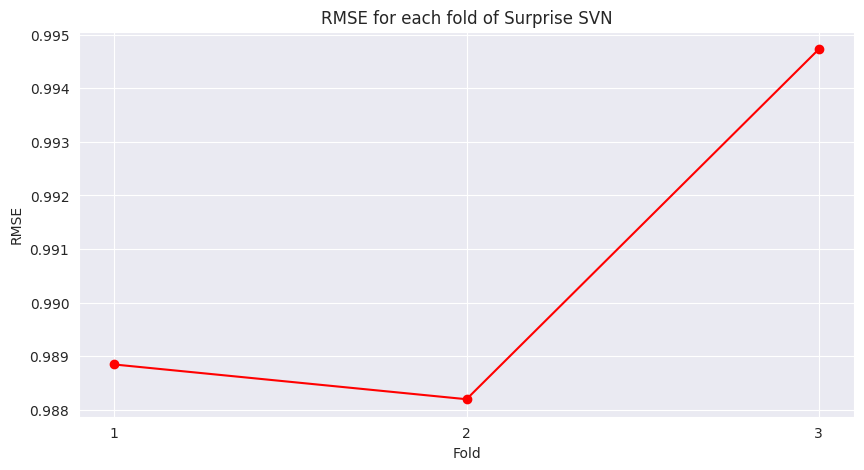

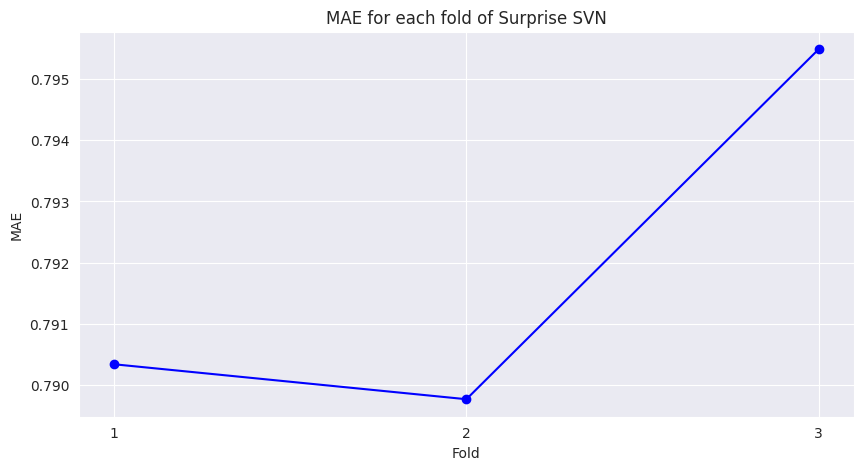

In [15]:

# Plot RMSE scores
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 4), rmse_values, marker='o', linestyle='-', color='r')
plt.title('RMSE for each fold of Surprise SVN')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.xticks(np.arange(1, 4))
plt.show()

# Plot MAE scores
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 4), mae_values, marker='o', linestyle='-', color='b')
plt.title('MAE for each fold of Surprise SVN')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.xticks(np.arange(1, 4))
plt.show()

Below is what user 401047 liked in the past:

In [16]:
df_401047 = df[(df['Cust_Id'] == 401047) & (df['Rating'] == 5)]
df_401047 = df_401047.set_index('Movie_Id')
df_401047 = df_401047.join(df_title)['Name']
print(df_401047)


Movie_Id
143                                          The Game
445                                   Michael Collins
607                                             Speed
798                                              Jaws
886                                               Ray
985                                         The Mummy
1073                                     Coach Carter
1173                           Walking with Dinosaurs
1220                                      Man on Fire
1625                      Aliens: Collector's Edition
1692                                    Lonesome Dove
1756                     Murder on the Orient Express
1790                                        Born Free
1798                                    Lethal Weapon
1799                           Die Hard 2: Die Harder
1803         Alien: Resurrection: Collector's Edition
2043                                            Shane
2152                                  What Women Want
2162               

Let's predict which movies user 114514 would love to watch:

In [17]:
user_401047 = df_title.copy().reset_index()
user_401047 = user_401047[~user_401047['Movie_Id'].isin(drop_movie_list)]


user_401047['Estimate_Score'] = user_401047['Movie_Id'].apply(lambda x: svd.predict(401047, x).est)

user_401047 = user_401047.drop('Movie_Id', axis = 1)

user_401047 = user_401047.sort_values('Estimate_Score', ascending=False)
print(user_401047.head(10))

         Year                                               Name  \
32     2000.0                     Aqua Teen Hunger Force: Vol. 1   
31     2004.0  ABC Primetime: Mel Gibson's The Passion of the...   
29     2003.0                             Something's Gotta Give   
17     1994.0                                   Immortal Beloved   
27     2002.0                                    Lilo and Stitch   
12896  2002.0                                        Unspeakable   
12901  2002.0                                        Big Trouble   
12900  1998.0                                           Star Kid   
12899  2001.0                                     Reba: Season 1   
12898  1976.0                                          Pinocchio   

       Estimate_Score  
32           4.178582  
31           3.857880  
29           3.394455  
17           3.320831  
27           3.281665  
12896        3.274470  
12901        3.274470  
12900        3.274470  
12899        3.274470  
12898      

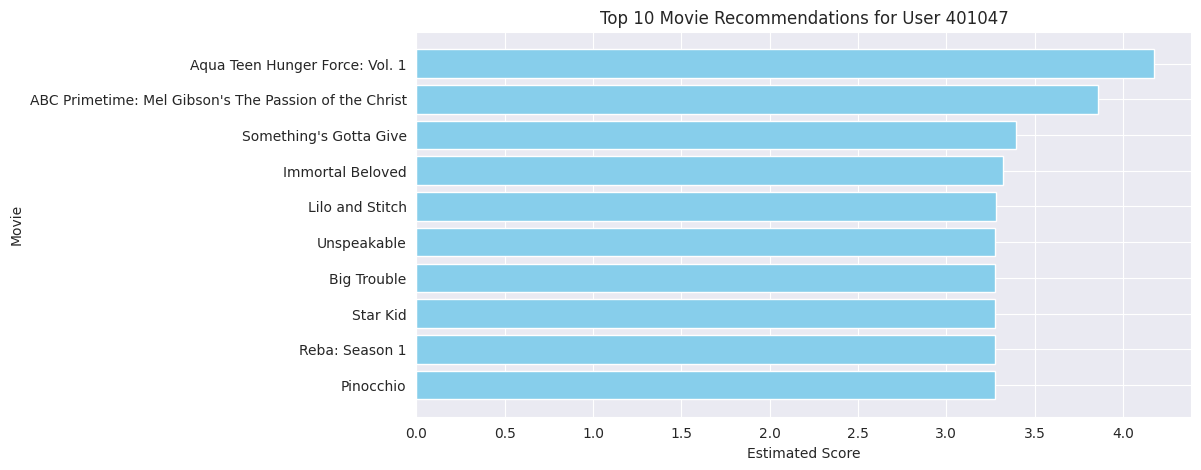

In [18]:
top_movies = user_401047.head(10)
plt.figure(figsize=(10, 5))
plt.barh(top_movies['Name'], top_movies['Estimate_Score'], color='skyblue')
plt.title('Top 10 Movie Recommendations for User 401047')
plt.xlabel('Estimated Score')
plt.ylabel('Movie')
plt.gca().invert_yaxis()
plt.show()

### Pearsons' R correlations

In this approach, we employ Pearson’s R correlation as a metric to quantify the linear relationship between the review scores of all possible pairs of movies. Subsequently, we present a list of the top ten movies that exhibit the highest correlations. This method allows us to identify films that are highly regarded in a similar manner, thereby providing valuable insights for recommendations.

In [19]:
def recommend(movie_title, min_count):
    # Print the movie for which recommendations are being made
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")

    # Get the index of the movie that matches the title
    i = int(df_title.index[df_title['Name'] == movie_title][0])

    # Retrieve the row of this movie from the similarity matrix. This row contains similarity scores with all other movies.
    target = df_p[i]

    # Compute pairwise correlation between the target movie and all other movies
    similar_to_target = df_p.corrwith(target)

    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])

    # Drop any null values from the dataframe
    corr_target.dropna(inplace = True)

    # Sort the dataframe by similarity scores in descending order
    corr_target = corr_target.sort_values('PearsonR', ascending = False)

    corr_target.index = corr_target.index.map(int)

    # Join the dataframes df_title and df_movie_summary to corr_target
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]

    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))


A recommendation for you if you like '#1799   Die Hard 2: Die Harder'

In [20]:
recommend("Die Hard 2: Die Harder", 0)

For movie (Die Hard 2: Die Harder)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                               Name  count     mean
 1.000000                                             Die Hard 2: Die Harder  62809 3.660065
 0.503048                                                    Lethal Weapon 3  75148 3.813807
 0.455355 Missing in Action 2: The Beginning / Missing in Action 3: Braddock   2297 3.057466
 0.443854                                      Under Siege 2: Dark Territory   9063 3.296591
 0.442952                                                      Lethal Weapon 113377 3.971317
 0.440787                                                    Out for Justice   6660 3.392042
 0.434394                                         Rambo: First Blood Part II  19240 3.432952
 0.431696                                                            Rocky V   8170 3.033660
 0.420941                                    The Substitute/The S

2782                                       Braveheart

In [21]:
recommend("Braveheart", 0)

For movie (Braveheart)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                            Name  count     mean
 1.000000                      Braveheart 135601 4.294423
 0.292888                The Last Samurai 139428 3.946596
 0.289452                   Lethal Weapon 113377 3.971317
 0.288157               Operation Pacific   1839 3.762915
 0.285428            The Fighting Seabees   4155 3.514320
 0.280299                        Rio Lobo   3693 3.832656
 0.279053 Dragon Ball Z: Super Android 13   2426 3.428689
 0.275931                         Rob Roy  11409 3.589009
 0.271564             The Devil's Brigade   2236 3.538909
 0.261248   Robin Hood: Prince of Thieves  44001 3.632917


References

- Gabrys, P. (2018). Non-negative matrix factorization for recommendation systems. Medium. Retrieved from https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c
- Gillis, N. (2014). The Why and How of Nonnegative Matrix Factorization. arXiv:1401.5226 [stat.ML].
- Hristakeva, M. (n.d.). A practical guide to building recommender systems. Retrieved from https://buildingrecommenders.wordpress.com/2015/11/18/overview-of-recommender-algorithms-part-2/
- Huang, S. (2018). Introduction to Recommender System. Part 1 (Collaborative Filtering, Singular Value Decomposition). Hackernoon. Retrieved from https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75
- Banik, R. (2018). Movies Recommender System. Kaggle. Retrieved from https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/notebook
- Netflix Inc. (2020). Netflix Prize data. Kaggle. Retrieved from https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data
- Google. (2022). Collaborative Filtering. Machine Learning | Google for Developers. Retrieved from https://developers.google.com/machine-learning/recommendation/collaborative
- Çano, E., & Morisio, M. (2019). Hybrid recommender systems: A systematic literature review. Intell. Data Anal., 21, 1487-1524.